In [ ]:
#sempre lembrar de limpar a pasta tmp ao final do exercício

# import shutil
# shutil.rmtree('/tmp_img')
# shutil.rmtree('/tmp_csv')
# shutil.rmtree('/tmp_img_resized')

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import numpy as np
import cv2
import glob
import os
import re
from google.colab import drive
from functools import lru_cache
import requests
import seaborn as sns
from google.colab import files

In [3]:
AUTOENCODER_WIDTH = 160
AUTOENCODER_HEIGHT = 192
RESCALE_RATIO = 35
states = ['AC', 'AL', 'AP', 'AM', 'BA', 'CE', 'ES', 'GO', 'MA', 'MT', 'MS', 'MG', 'PA', 'PB', 'PR', 'PE', 'PI', 'RJ', 'RN', 'RS', 'RO', 'RR', 'SC', 'SP', 'SE', 'TO', 'DF']

In [4]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Descomprimir todos os arquivos

Unzip Files (backend/data_source/data.py + backend/data_source/local_disk.py)

*já está no código python

In [5]:
def extract_files(input_folder, year, file, output_folder):
  from_path = f'{input_folder}/{str(year)}/{file}'
  zip_ref = zipfile.ZipFile(from_path, 'r')
  zip_ref.extractall(output_folder+'/'+str(year))
  zip_ref.close()

#está faltando o DF em 2018
def unzip_files(year):
  filename = 'consulta_cand_'+str(year)+'.zip'
  extract_files('/content/gdrive/MyDrive/Bootcamp_ENAP_2022', year, filename, '/tmp_csv')
  if year != 2014:
    for state in states:
      if year == 2018 and state == 'DF': continue
      filename = 'foto_cand'+str(year)+'_'+state+'_div.zip'
      extract_files('/content/gdrive/MyDrive/Bootcamp_ENAP_2022', year, filename, '/tmp_img')
  else:
    filename = 'foto_cand'+str(year)+'_div.zip'
    extract_files('/content/gdrive/MyDrive/Bootcamp_ENAP_2022', year, filename, '/tmp_img')

In [6]:
#unzip_files(2014)
#unzip_files(2018)
unzip_files(2022)

Processar todas as imagens

.env + backend/data_source/params.py

*já está no código python

In [7]:
CHUNK_SIZE = 1000
DATA_SOURCE = 'local'
LOCAL_DATA_PATH_INPUT_IMG = '/tmp_img'
LOCAL_DATA_PATH_CSV = '/tmp_csv'
LOCAL_DATA_PATH_OUTPUT_IMG = '/tmp_img_output'
COLUMN_NAMES = ['NM_CANDIDATO', 'DS_CARGO', 'SQ_CANDIDATO', 'DS_SIT_TOT_TURNO', 'CD_SIT_TOT_TURNO', 'ANO_ELEICAO', 'SG_UE']
COLUMN_NAMES_FULL = COLUMN_NAMES + ['filename']

backend/face_rec/face_detection.py

*já está no código python

In [8]:
def crop_face(face):
  face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_alt.xml')
  gray = None
  if len(face.shape) == 3:
    gray = cv2.cvtColor(face, cv2.COLOR_RGB2GRAY)
  else:
    gray = face = np.expand_dims(face, axis=-1)
  faces = face_cascade.detectMultiScale(gray, 1.3, 5)
  if len(faces):
    (x,y,w,h) = faces[0]
    w_slack, h_slack = w//2, h//2
    img_cropped = face[
        max(0,y-h_slack):
        min(face.shape[0]-1,y+h+h_slack), 
        max(0, x-w_slack):
        min(face.shape[1]-1,x+w+w_slack),
        :]
    return img_cropped
  else:
    square = min(face.shape[0], face.shape[1])//2
    mid_height = face.shape[0]//2
    mid_width = face.shape[1]//2
    return face[mid_height-square:mid_height+square,mid_width-square:mid_width+square]

def resize_face(face, x_max=AUTOENCODER_WIDTH, y_max=AUTOENCODER_HEIGHT):
  scale = min(y_max/face.shape[0], x_max/face.shape[1])
  return cv2.resize(face, None, fx=scale, fy=scale, interpolation=cv2.INTER_AREA)

def pad_face(face, x_max=AUTOENCODER_WIDTH, y_max=AUTOENCODER_HEIGHT):
  delta_w = x_max - face.shape[1]
  delta_h = y_max - face.shape[0]
  top, bottom = delta_h//2, delta_h-(delta_h//2)
  left, right = delta_w//2, delta_w-(delta_w//2)
  return cv2.copyMakeBorder(face, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[255, 255, 255])

def gray_face(face):
  return cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)

def is_gray(face):
    if len(face.shape) < 3: return True
    if face.shape[2]  == 1: return True
    b,g,r = face[:,:,0], face[:,:,1], face[:,:,2]
    if (b==g).all() and (b==r).all(): return True
    return False

backend/data_source/local_disk.py

*já está no código python

In [9]:
def open_image_local(path):
  img = cv2.imread(path, cv2.COLOR_BGR2RGB)
  return img

def get_pandas_chunk(year: str,
                     state: str,
                     index: int,
                     chunk_size: int,
                     verbose=True) -> pd.DataFrame:
    """
    return a chunk of the raw dataset from local disk or cloud storage
    """

    full_path = os.path.join(
        LOCAL_DATA_PATH_CSV, #os.path.expanduser(os.environ.get("LOCAL_DATA_PATH_CSV")),
        year,
        f"consulta_cand_{year}_{state}.csv")

    if verbose:
        print(f"Source data from {full_path}: {chunk_size if chunk_size is not None else 'all'} rows (from row {index})")

    try:
        df = pd.read_csv(
                full_path,
                skiprows=np.arange(1, index+1),  # skip header
                nrows=chunk_size,
                header=0, 
                encoding='iso-8859-1', 
                on_bad_lines='warn', 
                sep=';',
                usecols=COLUMN_NAMES)  # read all rows


        df['filename'] = df['SQ_CANDIDATO'].map(lambda sq_candidato: get_img_filename(year, state, sq_candidato))

    except pd.errors.EmptyDataError:
        return None  # end of data

    return df

def save_local_chunk(data: pd.DataFrame):
  """
  save a chunk of the dataset to local disk
  """

  for ind in data.index:
    state = data['SG_UE'][ind]
    year = str(data['ANO_ELEICAO'][ind])
    eleito = data['DS_SIT_TOT_TURNO'][ind]

    if eleito == "ELEITO" or eleito == "ELEITO POR MÉDIA":
      eleito = True
    elif eleito == "NÃO ELEITO":
      eleito = False
    else:
      continue

    sq_candidato = str(data['SQ_CANDIDATO'][ind])
    face = data['face'][ind]

    if is_gray(face):
      save_image_local(year+'F'+state+str(sq_candidato)+'_div.jpg', face, True, eleito)
    else:
      save_image_local(year+'F'+state+str(sq_candidato)+'_div.jpg', face, False, eleito)
      save_image_local(year+'F'+state+str(sq_candidato)+'_div.jpg', gray_face(face), True, eleito)

backend/data_source/data.py

*já está no código python

In [10]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    """
    clean raw data by removing buggy or irrelevant transactions
    or columns for the training set
    """
    
    # remove useless/redundant columns
    df = df[COLUMN_NAMES_FULL]
    df = df.dropna(subset=['filename'])

    print("✅ data cleaned")

    return df

def get_chunk(year: str,
              state: str,
              index: int = 0,
              chunk_size: int = None,
              verbose=False) -> pd.DataFrame:
    """
    Return a `chunk_size` rows from the source dataset, starting at row `index` (included)
    Always assumes `source_name` (CSV or Big Query table) have headers,
    and do not consider them as part of the data `index` count.
    """

    # if os.environ.get("DATA_SOURCE") == "big query":

    #     chunk_df = get_bq_chunk(table=source_name,
    #                             index=index,
    #                             chunk_size=chunk_size,
    #                             dtypes=dtypes,
    #                             verbose=verbose)

    #     return chunk_df

    chunk_df = get_pandas_chunk(year=year,
                                state=state,
                                index=index,
                                chunk_size=chunk_size,
                                verbose=verbose)

    return chunk_df


def save_image_local(filename, face, bw, eleito):
  folder = None

  if bw:
    folder = os.path.join(LOCAL_DATA_PATH_OUTPUT_IMG, "elected" if eleito else "not_elected",
                        #os.path.expanduser(os.environ.get("LOCAL_DATA_PATH_OUTPUT_IMG")),
                        'bw')
  else:
    folder = os.path.join(LOCAL_DATA_PATH_OUTPUT_IMG, "elected" if eleito else "not_elected",
                        #os.path.expanduser(os.environ.get("LOCAL_DATA_PATH_OUTPUT_IMG")),
                        'color')


  if not os.path.exists(folder):
    os.makedirs(folder)
  cv2.imwrite(os.path.join(folder, filename), face)

  return None

def save_chunk(data: pd.DataFrame) -> None:
    """
    save chunk
    """

    # if os.environ.get("DATA_SOURCE") == "big query":

    #     save_bq_chunk(table=destination_name,
    #                   data=data,
    #                   is_first=is_first)

    #     return

    save_local_chunk(data=data)



backend/data_source/main.py

In [11]:
def preprocess_chunk_images(year: str, state: str, df: pd.DataFrame) -> np.ndarray:
  def preprocess_image(filename: str) -> list:
    return pad_face(resize_face(crop_face(open_image_local(filename))))
  df['face'] = df['filename'].map(preprocess_image)
  return df

def preprocess_images(year: str, state: str):

    # iterate on the dataset, by chunks
    chunk_id = 0
    row_count = 0
    cleaned_row_count = 0
    #CHUNK_SIZE = os.environ.get("CHUNK_SIZE")

    while (True):

        print(f"\n{year}, {state}: Processing chunk n°{chunk_id}...")

        data_chunk = get_chunk(year=year,
                               state=state,
                               index=chunk_id * CHUNK_SIZE,
                               chunk_size=CHUNK_SIZE)

        # Break out of while loop if data is none
        if data_chunk is None:
            print("No data in latest chunk...")
            break

        row_count += data_chunk.shape[0]

        data_chunk_cleaned = clean_data(data_chunk)

        cleaned_row_count += len(data_chunk_cleaned)

        # break out of while loop if cleaning removed all rows
        if len(data_chunk_cleaned) == 0:
            print("\nNo cleaned data in latest chunk...")
            break

        images_processed_chunk = preprocess_chunk_images(year, state, data_chunk_cleaned)

        save_chunk(images_processed_chunk)

        chunk_id += 1

    if row_count == 0:
        print("\n✅ no new data for the preprocessing 👌")
        return None

    print(f"\n✅ data processed saved entirely: {row_count} rows ({cleaned_row_count} cleaned)")

    return None

def preprocess():
  for year in ['2014', '2018', '2022']:
    for state in states:
      if year != '2018' and state != 'DF':
        preprocess_images(year, state)

backend/data_source/utils.py

*já está no código python

In [12]:
def get_img_filename(year: str, state: str, sq_candidato: str):

  path = os.path.join(LOCAL_DATA_PATH_INPUT_IMG, #os.path.expanduser(os.environ.get("LOCAL_DATA_PATH_IMG")),
                      year)
  
  options = ['F'+state+str(sq_candidato)+'_div.jpg', 'F'+state+str(sq_candidato)+'_div.jpeg', 
             'F'+state+str(sq_candidato)+'.jpg', 'F'+state+str(sq_candidato)+'.jpeg']

  for option in options:
    full_path = os.path.join(path, option)
    if os.path.exists(full_path): return full_path
  return None

A partir daqui o código não foi migrado para o Python

In [100]:
def open_image_internet(url):
  return cv2.imdecode(np.asarray(bytearray(requests.get(url).content)), -1)

#plt.imshow reads an image in a different order of cv2.imread/cv2.imshow
#so, we always need to reverse channels
def BGR2RGB(img):
  return img[:,:,::-1]

@lru_cache(maxsize=None)
def get_img_filenames(year, state):
  os.chdir(f'/tmp_img/{year}')
  img_lists = [glob.glob(e) for e in ('*'+state+'*.jpg', '*'+state+'*.png', '*'+state+'*.jpeg')]
  img_list = [item for sublist in img_lists for item in sublist]
  return set(img_list)

def get_img_filename_from_sq_candidato(year, state, sq_candidato):
  filenames = get_img_filenames(year, state)
  option1, option2 = 'F'+state+str(sq_candidato)+'_div.jpg', 'F'+state+str(sq_candidato)+'_div.jpeg'
  if option1 in filenames:
    return '/tmp_img/'+year+'/'+option1
  elif option2 in filenames:
    return '/tmp_img/'+year+'/'+option2
  else:
    return None

def get_candidates_from_state(year, state):
  os.chdir(f'/tmp_csv/{year}')
  data_filename = glob.glob('*'+state+'.csv')
  data_df = pd.read_csv(r'/tmp_csv/'+year+'/'+data_filename[0], encoding='iso-8859-1', on_bad_lines='warn', sep=';')
  data_df['filename'] = data_df['SQ_CANDIDATO'].map(lambda sq_candidato: get_img_filename_from_sq_candidato(year, state, sq_candidato))
  data_df = data_df.dropna(subset=['filename'])
  return data_df[['NM_CANDIDATO', 'DS_CARGO', 'SQ_CANDIDATO', 'DS_SIT_TOT_TURNO', 'CD_SIT_TOT_TURNO', 'filename']]

def get_candidates(year):
  return pd.concat([get_candidates_from_state(year, state) for state in states])
def get_elected(candidate_df):
  return candidate_df.query('DS_SIT_TOT_TURNO == "ELEITO" or DS_SIT_TOT_TURNO == "ELEITO POR MÉDIA"') 
def get_not_elected(candidate_df):
  return candidate_df.query('DS_SIT_TOT_TURNO == "NÃO ELEITO"')
def crop_faces(faces):
  return np.array([crop_face(face) for face in faces])
def faces(df: pd.DataFrame) -> np.ndarray:
  return np.array([open_image_local(filename) for filename in df['filename'].values])
def pad_faces(faces):
  return np.array([pad_face(face) for face in faces])
def resize_faces(faces):
  return np.array([resize_face(face) for face in faces])
def flatten_faces(faces):
  return faces.reshape((faces.shape[0], np.prod(faces.shape[1:])))
def gray_faces(faces):
  return np.array([gray_face(face) for face in faces])



Play for Real

In [91]:
def see_cropped_faces(photos, cropped_photos, resized_cropped_photos, grayed_resized_cropped_faces, n_photos):
  n_cols = 4
  lines = np.random.choice(photos.shape[0], n_photos, replace=False)
  fig, axs = plt.subplots(n_photos, n_cols, figsize=(15,30))
  for idx, (img_orig, img_cropp, img_resized, img_grayed) in enumerate(zip(photos[lines], cropped_photos[lines], resized_cropped_photos[lines], grayed_resized_cropped_faces[lines])):
    axs[idx][0].imshow(BGR2RGB(img_orig));
    axs[idx][1].imshow(BGR2RGB(img_cropp));
    axs[idx][2].imshow(BGR2RGB(img_resized));
    axs[idx][3].imshow(img_grayed, cmap='gray');

Carregar Imagens

In [105]:
candidates_df = get_candidates('2022')
elected_df = get_elected(candidates_df)
elected_faces = faces(elected_df)
cropped_elected_faces = crop_faces(elected_faces)
resized_cropped_ellected_faces = pad_faces(resize_faces(cropped_elected_faces))
grayed_resized_cropped_ellected_faces = gray_faces(resized_cropped_ellected_faces)
elected_flattened_faces = flatten_faces(resized_cropped_ellected_faces)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Faces: variável com os rostos dos candidatos eleitos

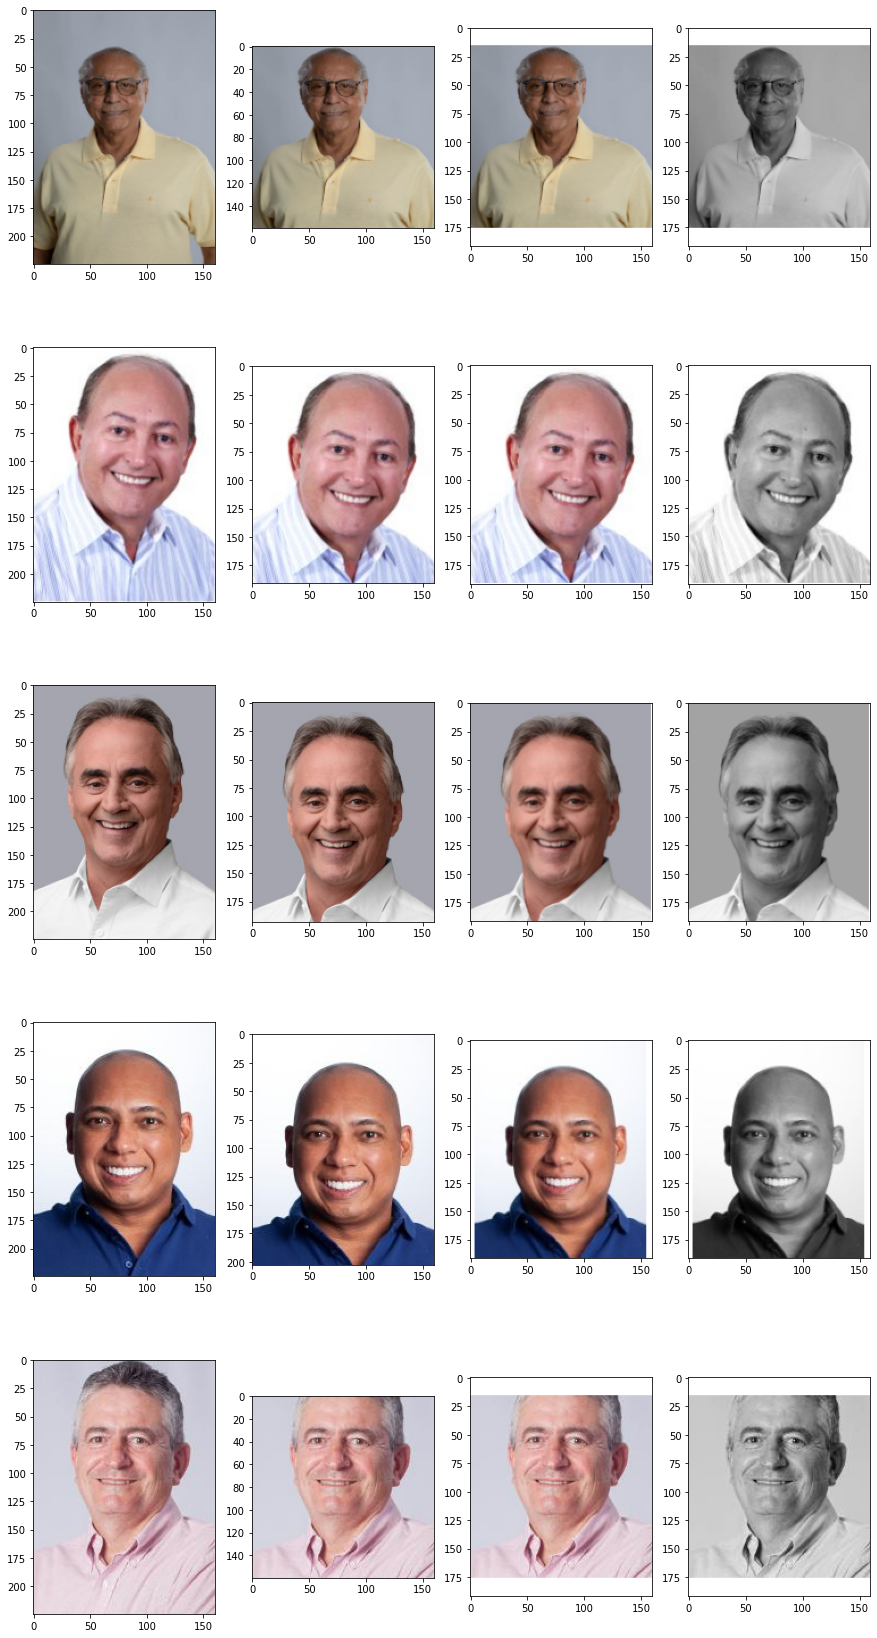

In [107]:
see_cropped_faces(elected_faces, cropped_elected_faces, resized_cropped_ellected_faces, grayed_resized_cropped_ellected_faces, 5)

PCA

Fonte: https://github.com/lewagon/data-challenges/blob/master/05-ML/06-Unsupervised-Learning/02-Face-Recognition/face_recognition.ipynb

In [108]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [109]:
def pca_plot_faces_and_their_reconstructions(pca, photos, n_photos):
  lines = np.random.choice(photos.shape[0], n_photos, replace=False)

  elected_person_images = photos[lines]

  flattened_faces = flatten_faces(elected_person_images)
  data_projected = pca.transform(flattened_faces)
  reconstructed_photos = pca.inverse_transform(data_projected).reshape((n_photos, photos.shape[1], photos.shape[2], photos.shape[3]))

  fig, axs = plt.subplots(n_photos, 2, figsize=(15,30))
  for idx, (img_orig, img_reconstructed) in enumerate(zip(elected_person_images, reconstructed_photos)):
    axs[idx][0].imshow(BGR2RGB(img_orig));
    axs[idx][1].imshow(BGR2RGB(img_reconstructed));

In [110]:
PCA_COMPONENTS = 100
N_COMPONENTS_TO_PLOT = 1

Construir o PCA dos candidatos eleitos com 10 componentes

In [111]:
pca = PCA(n_components=PCA_COMPONENTS, svd_solver='full').fit(elected_flattened_faces/255)

Play

Imagem Original vs. Reconstrução de uma Imagem 

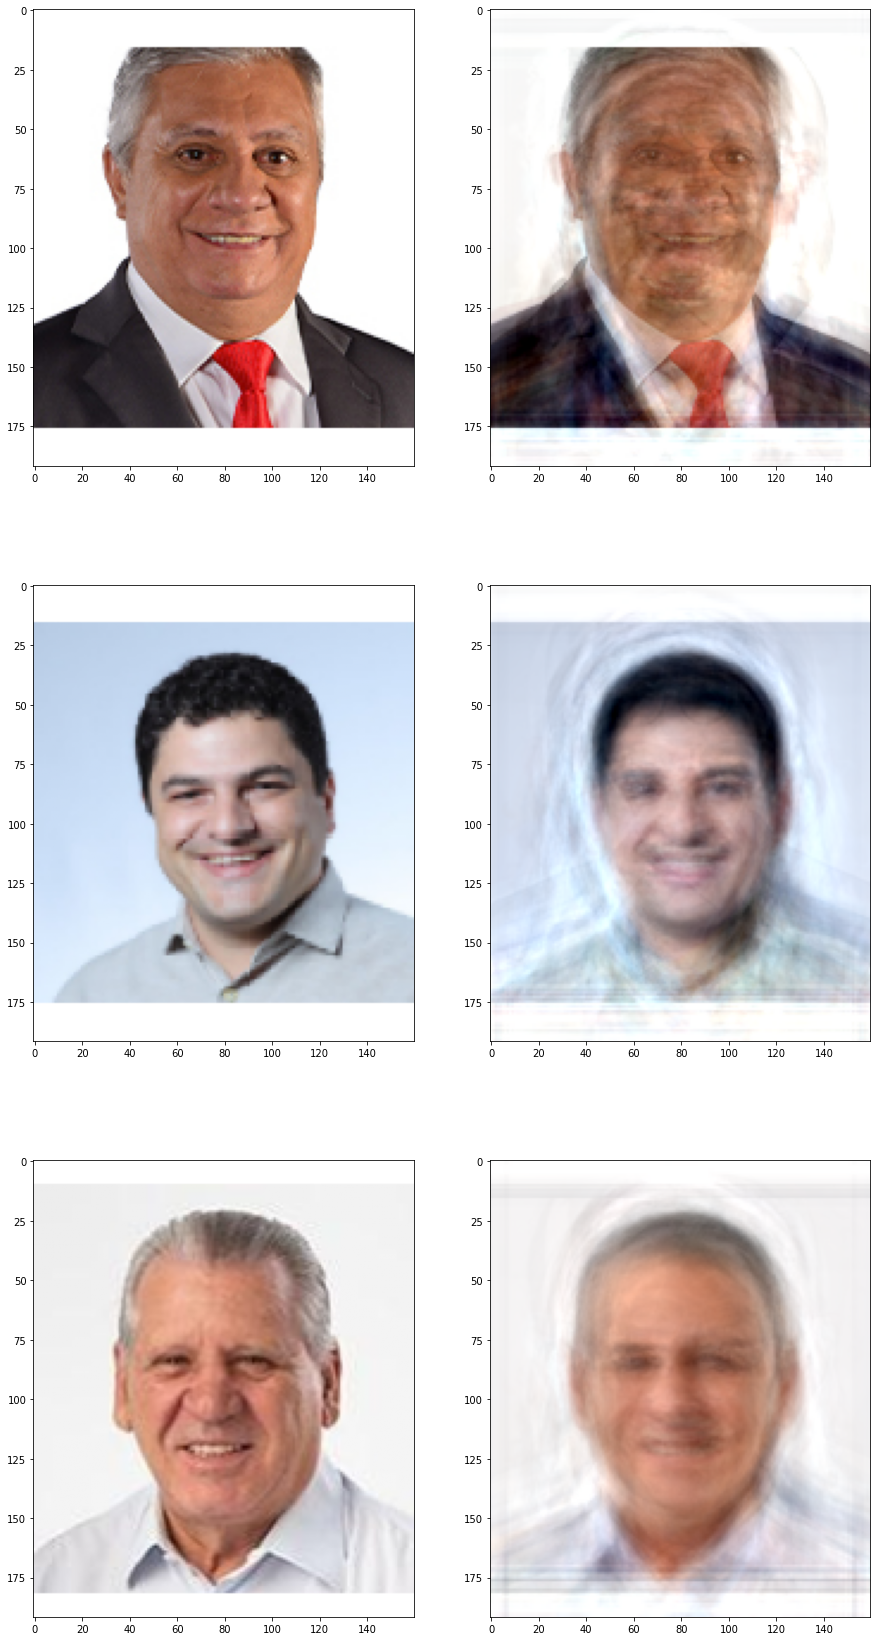

In [112]:
pca_plot_faces_and_their_reconstructions(pca, resized_cropped_ellected_faces/255, 3)

Imagens Reconstruídas

Reconstrução da imagem padrão de candidatos eleitos a partir do componente principal

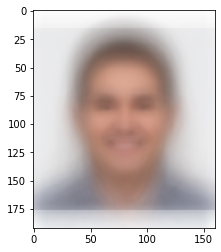

In [113]:
elected_mean_person_pca = pca.mean_.reshape(resized_cropped_ellected_faces.shape[1:])
plt.imshow(BGR2RGB(elected_mean_person_pca));

Busca pelo número ideal de componentes principais

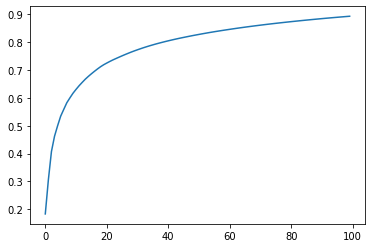

In [114]:
sns.lineplot(x=np.arange(pca.explained_variance_ratio_.shape[0]), y=pca.explained_variance_ratio_.cumsum())

Reconstrução da imagem padrão de candidatos eleitos a partir das componentes principais

In [115]:
def plot_main_components(pca, shape, n_components=1):
  sc = MinMaxScaler()
  sc = sc.fit(pca.components_)
  input_transformado = sc.transform(pca.components_[0:n_components])
  input_transformado = np.expand_dims(input_transformado.mean(axis=0), axis=1)
  input_transformado = input_transformado.reshape(shape)
  plt.imshow(BGR2RGB(input_transformado));

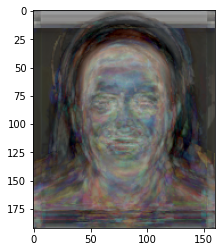

In [116]:
plot_main_components(pca, resized_cropped_ellected_faces.shape[1:], N_COMPONENTS_TO_PLOT)

Autoencoder

Fonte: https://github.com/heliomacedofilho/data-challenges/blob/master/06-Deep-Learning/03-Convolutional-Neural-Networks/05-Autoencoder/autoencoders.ipynb

In [117]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Reshape, Conv2DTranspose, Input, BatchNormalization, Dropout, Lambda, LeakyReLU, Masking
from tensorflow.keras import Model, backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from keras.layers import Embedding
from sklearn.model_selection import train_test_split

In [118]:
latent_dimension = 500

In [119]:
def plot_history(history):
  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

  ax1.plot(history.history['loss'], label='train')
  ax1.set_title('loss')
  ax1.legend()

  ax2.plot(history.history['r_loss'], label='train r_loss')
  ax2.plot(history.history['kl_loss'], label='train kl_loss')

  ax2.set_title('Accuracy')
  ax2.legend()
  return (ax1, ax2)
  
def autoencoder_plot_faces_and_their_reconstructions(autoencoder, photos, n_photos):
  lines = np.random.choice(photos.shape[0], n_photos, replace=False)
  reconstructed_photos = autoencoder.predict(photos[lines])

  fig, axs = plt.subplots(n_photos, 2, figsize=(15,30))
  for idx, (img_orig, img_reconstructed) in enumerate(zip(photos[lines], reconstructed_photos)):
    axs[idx][0].imshow(BGR2RGB(img_orig));
    axs[idx][1].imshow(BGR2RGB(img_reconstructed));

def plot_randomly_created_faces(decoder, n_photos):
  randomly_created_faces = decoder.predict(np.random.normal(0,1,size=(n_photos,latent_dimension)))

  fig, axs = plt.subplots(1, n_photos, figsize=(15,30))
  for idx, randomly_created_face in enumerate(randomly_created_faces):
    axs[idx].imshow(BGR2RGB(randomly_created_face));


In [121]:
candidates_df = get_candidates('2022')

elected_df = get_elected(candidates_df)[['filename']].copy()
elected_df['y'] = 1

not_elected_df = get_not_elected(candidates_df)[['filename']]
not_elected_indices = np.random.choice(not_elected_df.shape[0], elected_df.shape[0], replace=False)
not_elected_df = not_elected_df.iloc[not_elected_indices].copy()
not_elected_df['y'] = 0

#candidates_df = pd.concat([elected_df, not_elected_df], axis=0).sample(frac=1)
candidates_df = elected_df

In [123]:
X = pad_faces(resize_faces(crop_faces(faces(candidates_df.drop(columns='y')))))
y = candidates_df['y']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Encoder, Decoder e Autoencoder

In [125]:
def build_prefix_encoder(input_shape, use_batch_norm = False, use_dropout = False):
    # Clear tensorflow session to reset layer index numbers to 0 for LeakyRelu, 
    # BatchNormalization and Dropout.
    # Otherwise, the names of above mentioned layers in the model 
    # would be inconsistent
    global K
    K.clear_session()

    '''returns an encoder model, of output_shape equals to latent_dimension'''
    encoder = Sequential()
    
    encoder.add(Masking(mask_value=255, input_shape=input_shape))

    encoder.add(Rescaling(1./255))

    encoder.add(Conv2D(32, (3,3), (2, 2), padding='same', activation='LeakyReLU'))
    if use_batch_norm: encoder.add(BatchNormalization())
    if use_dropout: encoder.add(Dropout(0.25))

    encoder.add(Conv2D(64, (3,3), (2, 2), padding='same', activation='LeakyReLU'))
    if use_batch_norm: encoder.add(BatchNormalization())
    if use_dropout: encoder.add(Dropout(0.25))

    encoder.add(Conv2D(64, (3,3), (2, 2), padding='same', activation='LeakyReLU'))
    if use_batch_norm: encoder.add(BatchNormalization())
    if use_dropout: encoder.add(Dropout(0.25))

    encoder.add(Conv2D(64, (3,3), (2, 2), padding='same', activation='LeakyReLU'))
    if use_batch_norm: encoder.add(BatchNormalization())
    if use_dropout: encoder.add(Dropout(0.25))

    shape_before_flattening = K.int_shape(encoder.layers[-1].output)[1:] 

    encoder.add(Flatten())

    return encoder, shape_before_flattening

def build_suffix_encoder(prefix_model, latent_dimension):
  prefix_model_input = prefix_model.layers[0].input
  prefix_model_output = prefix_model.layers[-1].output

  mean_mu = Dense(latent_dimension)(prefix_model_output)
  log_var = Dense(latent_dimension)(prefix_model_output)

  # Defining a function for sampling
  def sampling(args):
    global mean_mu
    global log_var
    mean_mu, log_var = args
    epsilon = K.random_normal(shape=K.shape(mean_mu), mean=0., stddev=1.) 
    return mean_mu + K.exp(log_var/2)*epsilon

  concatenate = Lambda(sampling)([mean_mu, log_var])
  return Model(prefix_model_input, concatenate)

def build_encoder(input_shape, use_batch_norm = False, use_dropout = False, latent_dimension=200):
  prefix_encoder, shape_before_flattening = build_prefix_encoder(input_shape, use_batch_norm, use_dropout)
  encoder = build_suffix_encoder(prefix_encoder, latent_dimension)
  return encoder, shape_before_flattening

def build_decoder(input_shape, latent_dimension, shape_before_flattening):
  decoder = Sequential()
  decoder.add(Dense(np.prod(shape_before_flattening), input_shape=(latent_dimension, ), activation=None))
  decoder.add(Reshape(shape_before_flattening))
  decoder.add(Conv2DTranspose(64, kernel_size=(3,3), strides=(2,2), padding='same', activation='LeakyReLU'))
  decoder.add(Conv2DTranspose(64, kernel_size=(3,3), strides=(2,2), padding='same', activation='LeakyReLU'))
  decoder.add(Conv2DTranspose(32, kernel_size=(3,3), strides=(2,2), padding='same', activation='LeakyReLU'))
  decoder.add(Conv2DTranspose(3, kernel_size=(3,3), strides=(2,2), padding='same', activation='sigmoid'))
  return decoder

def build_autoencoder(input_shape, latent_dimension):
  encoder, shape_before_flattening = build_encoder(input_shape, True, True, latent_dimension)
  decoder = build_decoder(encoder.layers[-1].output, latent_dimension, shape_before_flattening)
  autoencoder = Model(encoder.layers[0].input, decoder(encoder.layers[-1].output))
  return autoencoder, encoder, decoder

In [126]:
autoencoder, encoder, decoder = build_autoencoder(X_train.shape[1:], latent_dimension)

Autoencoder

In [127]:
autoencoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 masking_input (InputLayer)     [(None, 192, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 masking (Masking)              (None, 192, 160, 3)  0           ['masking_input[0][0]']          
                                                                                                  
 rescaling (Rescaling)          (None, 192, 160, 3)  0           ['masking[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 96, 80, 32)   896         ['rescaling[0][0]']        

Encoder

In [128]:
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 masking_input (InputLayer)     [(None, 192, 160, 3  0           []                               
                                )]                                                                
                                                                                                  
 masking (Masking)              (None, 192, 160, 3)  0           ['masking_input[0][0]']          
                                                                                                  
 rescaling (Rescaling)          (None, 192, 160, 3)  0           ['masking[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 96, 80, 32)   896         ['rescaling[0][0]']          

Decoder

In [129]:
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 7680)              3847680   
                                                                 
 reshape (Reshape)           (None, 12, 10, 64)        0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 24, 20, 64)       36928     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 48, 40, 64)       36928     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 96, 80, 32)       18464     
 ranspose)                                                       
                                                      

Treino

Epoch 1/2
12/11 [===============================] - ETA: 0s - loss: 1352.2213 - r_loss: 0.0718 - kl_loss: 634.6964

11/11 [==============================] - 20s 2s/step - loss: 1352.2213 - r_loss: 0.0718 - kl_loss: 634.6964
Epoch 2/2
12/11 [===============================] - ETA: 0s - loss: 1075.9253 - r_loss: 0.0551 - kl_loss: 524.6406

11/11 [==============================] - 15s 1s/step - loss: 1075.9253 - r_loss: 0.0551 - kl_loss: 524.6406


(<matplotlib.axes._subplots.AxesSubplot at 0x7efda71bf090>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7efda7071510>)

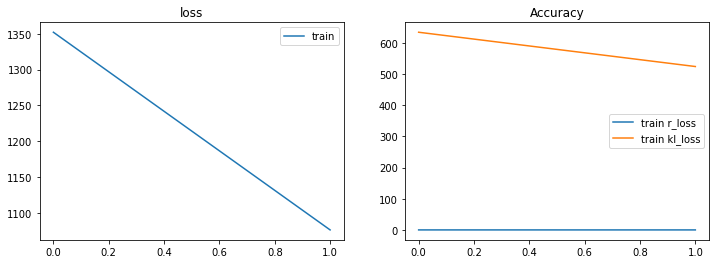

In [131]:
LEARNING_RATE = 0.0005
N_EPOCHS = 500
LOSS_FACTOR = 10000
BATCH_SIZE = 32

def r_loss(y_true, y_pred):
    return K.mean(K.square(y_true - y_pred), axis = [1,2,3])
  
def kl_loss(y_true, y_pred):
    kl_loss =  -0.5 * K.sum(1 + log_var - K.square(mean_mu) - K.exp(log_var), axis = 1)
    return kl_loss

def total_loss(y_true, y_pred):
    return LOSS_FACTOR*r_loss(y_true, y_pred) + kl_loss(y_true, y_pred)
  
adam_optimizer = Adam(learning_rate = LEARNING_RATE)

autoencoder.compile(optimizer=adam_optimizer, loss = total_loss, metrics = [r_loss, kl_loss])

#checkpoint_vae = ModelCheckpoint(os.path.join(WEIGHTS_FOLDER, 'VAE/weights.h5'), save_weights_only = True, verbose=1)
es = EarlyStopping(patience=5, restore_best_weights=True)

history = autoencoder.fit(X_train, X_train/255,
                shuffle=True,
                epochs = N_EPOCHS,
                initial_epoch = 0,
                steps_per_epoch=X_train.shape[0] / BATCH_SIZE,
                callbacks=es)
                #callbacks=[checkpoint_vae])

plot_history(history)

Play

Reconstituir fotos de candidatos eleitos

1/1 [==============================] - 1s 1s/step


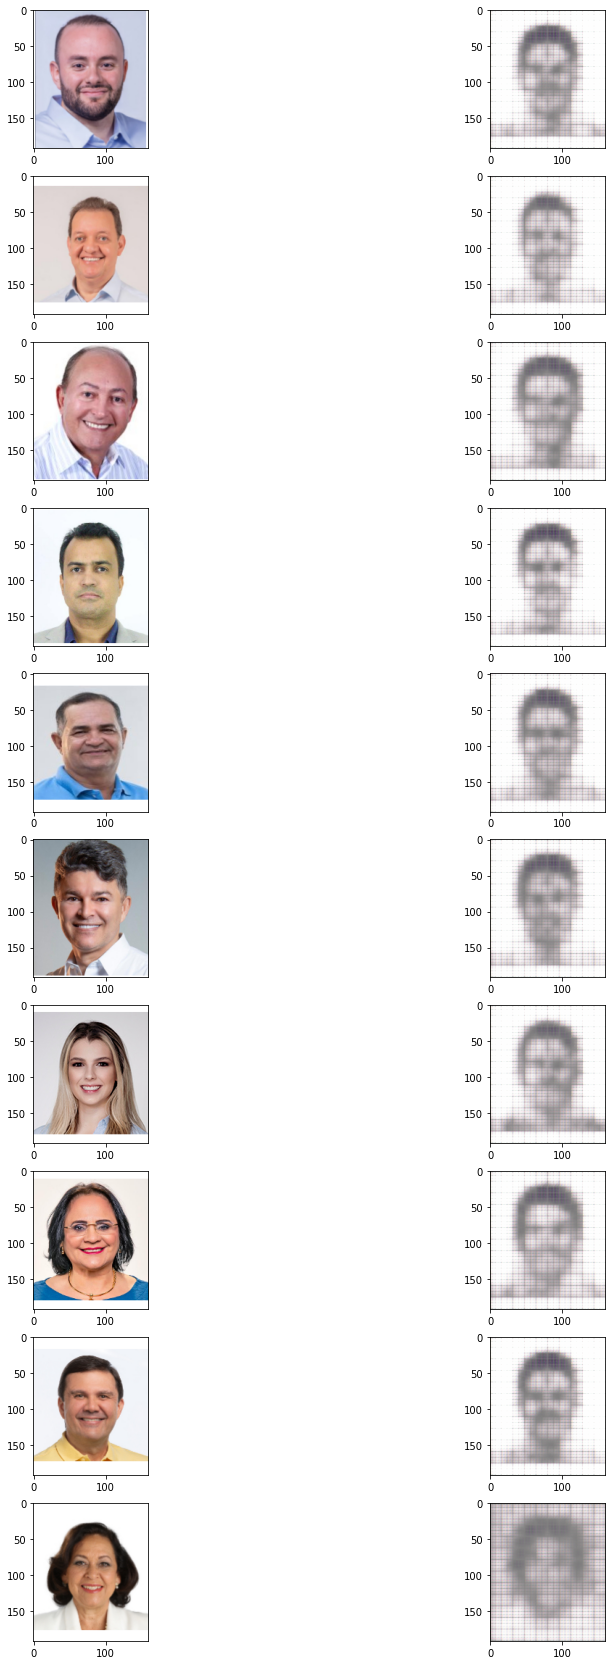

In [132]:
autoencoder_plot_faces_and_their_reconstructions(autoencoder, X_train, 10)

Criar aleatoriamente rosto de candidato eleito

1/1 [==============================] - 0s 200ms/step


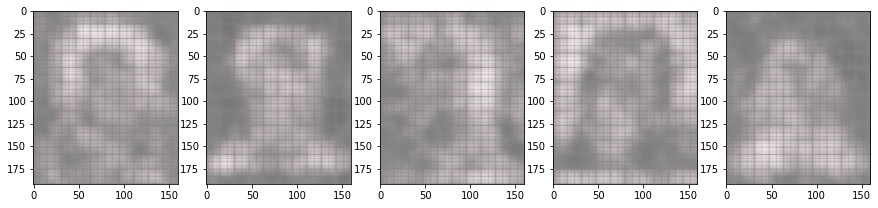

In [133]:
plot_randomly_created_faces(decoder, 5)

Reconstrução de faces a partir de candidatos não presentes no treino

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


1/1 [==============================] - 0s 425ms/step


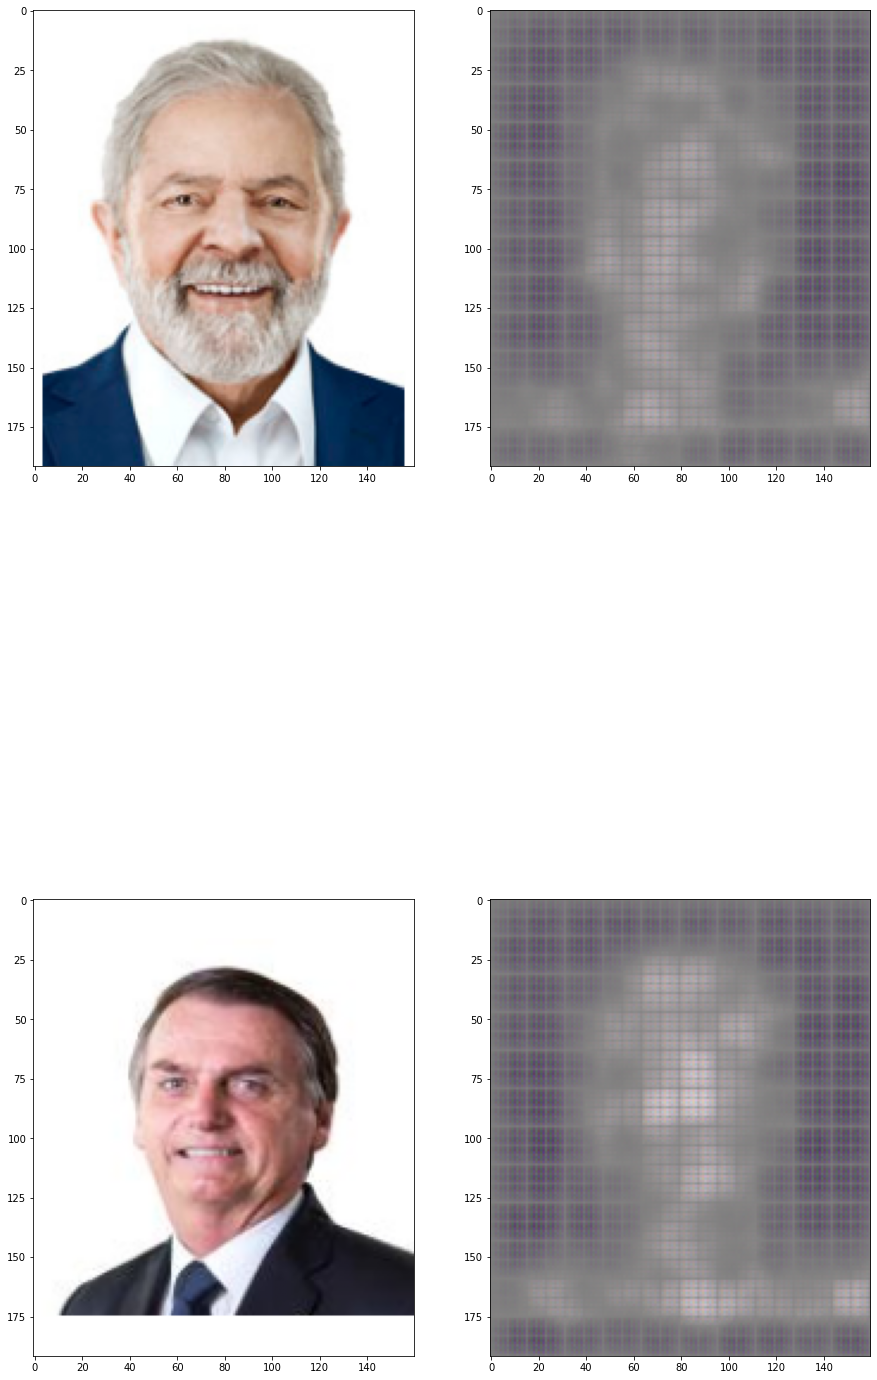

In [134]:
url_foto_lula = 'https://divulgacandcontas.tse.jus.br/candidaturas/oficial/2022/BR/BR/544/candidatos/893498/foto.jpg'
url_foto_bolsonaro = 'https://divulgacandcontas.tse.jus.br/candidaturas/oficial/2022/BR/BR/544/candidatos/908966/foto.jpeg'
foto_lula = open_image_internet(url_foto_lula)
foto_bolsonaro = open_image_internet(url_foto_bolsonaro)
presidenciaveis = pad_faces(resize_faces(crop_faces([foto_lula, foto_bolsonaro])))/255
autoencoder_plot_faces_and_their_reconstructions(autoencoder, presidenciaveis, presidenciaveis.shape[0])

Reconstrução de faces a partir de candidatos eleitos

17/17 [==============================] - 7s 383ms/step


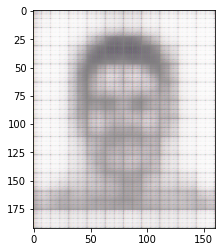

In [135]:
elected_mean_person_autoencoder = autoencoder.predict(X)
elected_mean_person_autoencoder = elected_mean_person_autoencoder.reshape((elected_mean_person_autoencoder.shape[0], np.prod(elected_mean_person_autoencoder.shape[1:]))).mean(axis=0).reshape(elected_mean_person_autoencoder.shape[1:])
plt.imshow(BGR2RGB(elected_mean_person_autoencoder))

Todo List

Save Model (It is not saving properly. Fix me!)

In [136]:
import pickle
import time
LOCAL_REGISTRY_PATH='/content/autoencoder'

if not os.path.exists(LOCAL_REGISTRY_PATH):
  os.makedirs(LOCAL_REGISTRY_PATH)
os.chdir(LOCAL_REGISTRY_PATH)

def save_model(model: Model = None,
               params: dict = None,
               metrics: dict = None) -> None:
    """
    persist trained model, params and metrics
    """

    timestamp = time.strftime("%Y%m%d-%H%M%S")

    # save params
    if params is not None:
        params_path = os.path.join(LOCAL_REGISTRY_PATH, "params", timestamp + ".pickle")
        print(f"- params path: {params_path}")
        with open(params_path, "wb") as file:
            pickle.dump(params, file)

    # save metrics
    if metrics is not None:
        metrics_path = os.path.join(LOCAL_REGISTRY_PATH, "metrics", timestamp + ".pickle")
        print(f"- metrics path: {metrics_path}")
        with open(metrics_path, "wb") as file:
            pickle.dump(metrics, file)

    # save model
    if model is not None:
        model_path = os.path.join(LOCAL_REGISTRY_PATH, "models", timestamp + ".model")
        print(f"- model path: {model_path}")
        model.save(model_path)

    print("\n✅ data saved locally")

    return None

In [137]:
save_model(autoencoder)

- model path: /content/autoencoder/models/20221121-054051.model



✅ data saved locally


Load Model (Loading and Downloading is Not Working. Fix me!)

In [138]:
from tensorflow.keras import models

def load_model(save_copy_locally=False, download=False) -> Model:
    """
    load the latest saved model, return None if no model found
    """
    # get latest model version
    model_directory = os.path.join(LOCAL_REGISTRY_PATH, "models")

    results = glob.glob(f"{model_directory}/*")
    if not results:
        return None

    model_path = sorted(results)[-1]
    print(f"- path: {model_path}")

    if download: 
      files.download(model_path)
    else:
      model = models.load_model(model_path)
      print("\n✅ model loaded from disk")
      return model

In [139]:
load_model(download=True)
#model = load_model(download=False)

- path: /content/autoencoder/models/20221121-054051.model


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>